In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from gptools.stan import compile_model

import cmdstanpy
cmdstanpy.install_cmdstan()


/root/.cache/pypoetry/virtualenvs/stan-env-Zdpe4cqc-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CmdStan install directory: /root/.cmdstan
CmdStan version 2.33.1 already installed
Test model compilation


True

In [3]:
# !pip install nest_asyncio

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [5]:
df = pd.read_csv('quality_nj2.csv')
#df = df[(df['YEAR_CODE'] == 1) & (df['MONTH_CODE'] == 1)]
from sklearn.preprocessing import LabelEncoder
encoder1, encoder2, encoder3 = LabelEncoder(), LabelEncoder(), LabelEncoder()
df['RATING_EVENT_CODE'] = encoder1.fit_transform(df['RATING_EVENT'])
df['ENTRY_NAME_CODE'] = encoder2.fit_transform(df['ENTRY_NAME'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
# The categorical variables are now encoded with numerical values

In [6]:
plt_coords = df.groupby('PLT_ID_CODE')[['ROW','COL']].mean()
from scipy.spatial.distance import cdist
coords = np.array([plt_coords['ROW'].values, plt_coords['COL'].values])
distances = cdist(coords.T,coords.T, metric='euclidean')
distances
# The 'distance_matrix' is now an n x n NumPy array containing the Euclidean distances

array([[ 0.        ,  1.        ,  2.        , ..., 17.2626765 ,
        17.11724277, 17.02938637],
       [ 1.        ,  0.        ,  1.        , ..., 17.11724277,
        17.02938637, 17.        ],
       [ 2.        ,  1.        ,  0.        , ..., 17.02938637,
        17.        , 17.02938637],
       ...,
       [17.2626765 , 17.11724277, 17.02938637, ...,  0.        ,
         1.        ,  2.        ],
       [17.11724277, 17.02938637, 17.        , ...,  1.        ,
         0.        ,  1.        ],
       [17.02938637, 17.        , 17.02938637, ...,  2.        ,
         1.        ,  0.        ]])

In [7]:
plt_coords['ROW'].astype(int)

PLT_ID_CODE
0       1
1       1
2       1
3       1
4       1
       ..
262    18
263    18
264    18
265    18
266    18
Name: ROW, Length: 267, dtype: int64

In [9]:
import stan
#fourier model
padding = 5 # adjustable
num_rows = 18
num_cols = 15
stan_data_fourier = {"N": len(df["QUALITY"]),
             "I":len(df['RATING_EVENT'].unique()),
             "J":len(df['ENTRY_NAME'].unique()),
             "P":len(df['PLT_ID'].unique()),
             "M": 9,
             "ii": df["RATING_EVENT_CODE"].values+1,
             "jj": df["ENTRY_NAME_CODE"].values+1,
             "pp": df["PLT_ID_CODE"].values+1,
             "y": df["QUALITY"].values,
             "DIST": distances,
              # new values
             "num_rows": num_rows,
             "num_cols": num_cols,
             "num_rows_padded": num_rows + padding,
             "num_cols_padded": num_cols + padding,
             "plot_row" : plt_coords["ROW"].astype(int),
             "plot_col" : plt_coords["COL"].astype(int)
              }
#fourier_model = compile_model(stan_file="simple_fourier_model_4.stan", force_compile=True)

In [12]:
fourier_model_exp_quad = compile_model(stan_file="simple_fourier_model_7.stan", force_compile=True)

16:37:13 - cmdstanpy - WARNING - CmdStanModel(compile=...) is deprecated and will be removed in the next major version. The constructor will always ensure a model has a compiled executable.
If you wish to force recompilation, use force_compile=True instead.
16:37:13 - cmdstanpy - INFO - compiling stan file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_7.stan to exe file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_7
16:37:39 - cmdstanpy - INFO - compiled model executable: /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_7


In [13]:
#fit = adv_model.sample(num_chains=1, num_samples=200)
fit_exp_quad = fourier_model_exp_quad.sample(stan_data_fourier)

16:37:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                 | 00:00 Status
chain 2 |                                                                                                 | 00:00 Status

chain 3 |                                                                                                 | 00:00 Status


chain 1 |████▍                                                                                            | 00:00 Status

chain 3 |████▍                                                                                            | 00:00 Status


chain 4 |████▍                                                                                            | 00:00 Status
chain 2 |████▍                                                                                            | 00:00 Status16:38:25 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 2 Unknown error -2
16:38

KeyboardInterrupt: 

Text(0.5, 1.0, 'Matern 3/2 Plot Covariance')

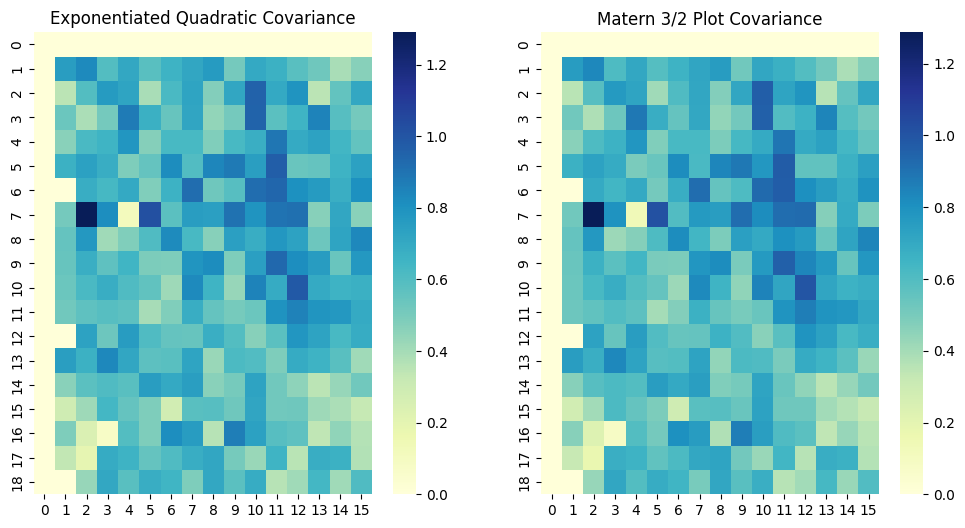

In [95]:
mean_matrix_exp_quad = np.zeros((np.max(PLT_ROW)+1, np.max(PLT_COL)+1))
mean_matrix_exp_quad[PLT_ROW, PLT_COL] = fit_exp_quad.plot.mean(axis=0)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(mean_matrix_exp_quad, cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Exponentiated Quadratic Covariance")
sns.heatmap(mean_matrix, cmap="YlGnBu", ax=axes[1])
axes[1].set_title("Matern 3/2 Plot Covariance")

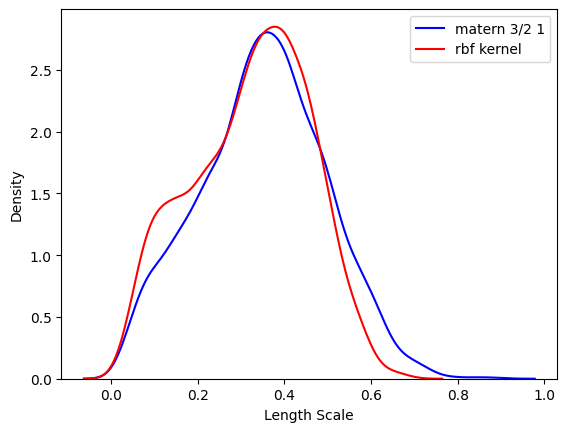

In [96]:
sns.kdeplot(fit.length_scale, color='blue', label='matern 3/2 1')

# Plot the second KDE line
sns.kdeplot(fit_exp_quad.length_scale, color='red', label='rbf kernel')

# Customize the plot
plt.xlabel('Length Scale')
plt.ylabel('Density')
plt.legend()


In [82]:
fit_exp_quad.entry

array([[-0.0501333 ,  0.162439  ,  1.11251   , ..., -0.0158913 ,
         0.00684122, -0.719072  ],
       [-0.406044  ,  0.382863  ,  1.12521   , ...,  0.0256771 ,
         0.14865   , -0.621808  ],
       [ 0.0618745 ,  0.336619  ,  1.26492   , ..., -0.0848512 ,
         0.0414836 , -0.174872  ],
       ...,
       [ 0.175744  ,  0.687111  ,  0.955491  , ...,  0.0362339 ,
         0.60087   , -0.203068  ],
       [ 0.136662  ,  0.606996  ,  1.84882   , ...,  0.342649  ,
         0.326278  , -0.146525  ],
       [ 0.195493  ,  0.765944  ,  1.42252   , ...,  0.325812  ,
         0.246883  , -0.502298  ]])

In [84]:
fourier_model_exp_quad_bigls = compile_model(stan_file="simple_fourier_model_6.stan", force_compile=True)

12:40:34 - cmdstanpy - WARNING - CmdStanModel(compile=...) is deprecated and will be removed in the next major version. The constructor will always ensure a model has a compiled executable.
If you wish to force recompilation, use force_compile=True instead.
12:40:34 - cmdstanpy - INFO - compiling stan file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_6.stan to exe file /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_6
12:41:05 - cmdstanpy - INFO - compiled model executable: /home/hok/oxb_econ/stan-env/stan_env/simple_fourier_model_6


In [90]:
fit_exp_quad_bigls = fourier_model_exp_quad_bigls.sample(stan_data_fourier)

12:42:49 - cmdstanpy - INFO - CmdStan start processing












chain 1 |                                                                      | 00:00 Status












chain 2 |                                                                      | 00:00 Status













chain 3 |                                                                      | 00:00 Status














chain 4 |                                                                      | 00:00 Status














chain 4 |███▏                                                                  | 00:00 Status













chain 3 |███▏                                                                  | 00:00 Status











chain 1 |███▏                                                                  | 00:00 Status












chain 2 |███▏                                                                  | 00:00 Status














chain 4 |███▎                                 | 07:46 Iteration:    1 / 2000 [


13:29:41 - cmdstanpy - INFO - CmdStan done processing.
13:29:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'simple_fourier_model_6.stan', line 93, column 2 to column 27)
Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'simple_fourier_model_6.stan', line 13, column 4 to column 40) (in 'simple_fourier_model_6.stan', line 104, column 1 to column 65)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'simple_fourier_model_6.stan', line 13, column 4 to column 40) (in 'simple_fourier_model_6.stan', line 104, column 1 to column 65)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'simple_fourier_model_6.stan', line 13, colu

Text(0.5, 1.0, 'Matern 3/2 Plot Covariance')

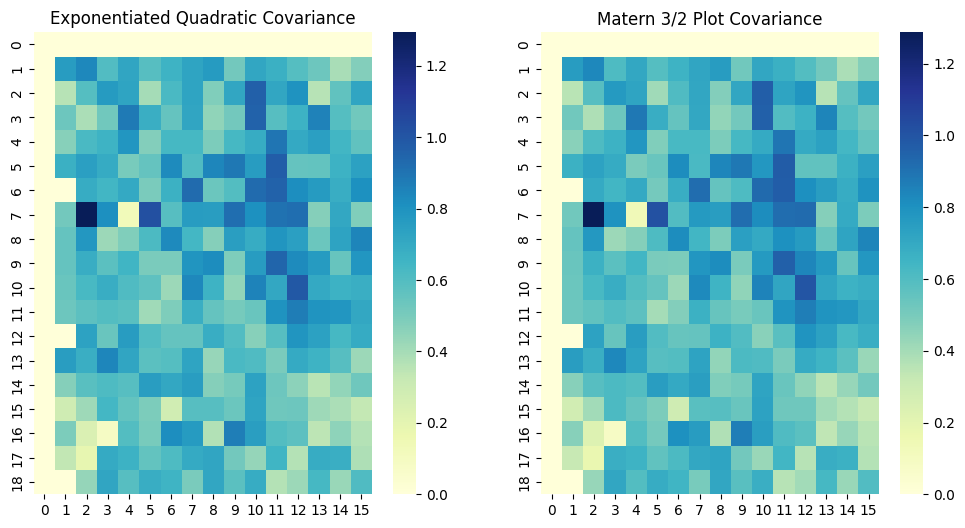

In [91]:
mean_matrix_exp_quad = np.zeros((np.max(PLT_ROW)+1, np.max(PLT_COL)+1))
mean_matrix_exp_quad[PLT_ROW, PLT_COL] = fit_exp_quad_bigls.plot.mean(axis=0)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(mean_matrix_exp_quad, cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Exponentiated Quadratic Covariance")
sns.heatmap(mean_matrix, cmap="YlGnBu", ax=axes[1])
axes[1].set_title("Matern 3/2 Plot Covariance")

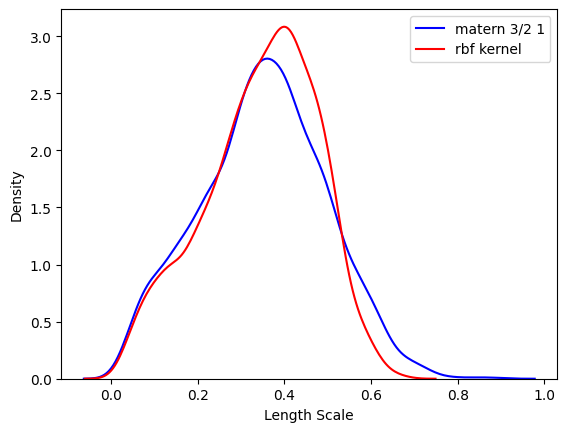

In [92]:
sns.kdeplot(fit.length_scale, color='blue', label='matern 3/2 1')

# Plot the second KDE line
sns.kdeplot(fit_exp_quad_bigls.length_scale, color='red', label='rbf kernel')

# Customize the plot
plt.xlabel('Length Scale')
plt.ylabel('Density')
plt.legend()


In [27]:
fourier_model_t = compile_model(stan_file="fourier_model_time_effect.stan", force_compile=True)

17:29:51 - cmdstanpy - WARNING - CmdStanModel(compile=...) is deprecated and will be removed in the next major version. The constructor will always ensure a model has a compiled executable.
If you wish to force recompilation, use force_compile=True instead.
17:29:51 - cmdstanpy - INFO - compiling stan file /home/hok/oxb_econ/stan-env/stan_env/fourier_model_time_effect.stan to exe file /home/hok/oxb_econ/stan-env/stan_env/fourier_model_time_effect
17:30:27 - cmdstanpy - INFO - compiled model executable: /home/hok/oxb_econ/stan-env/stan_env/fourier_model_time_effect


In [19]:
df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear

/tmp/ipykernel_504/68292059.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear


In [28]:
padding = 5 # adjustable
num_rows = 18
num_cols = 15
stan_data_time = {"N": len(df["QUALITY"]),
             "I":len(df['RATING_EVENT'].unique()),
             "J":len(df['ENTRY_NAME'].unique()),
             "P":len(df['PLT_ID'].unique()),
             "M": 9,
             "ii": df["RATING_EVENT_CODE"].values+1,
             "jj": df["ENTRY_NAME_CODE"].values+1,
             "pp": df["PLT_ID_CODE"].values+1,
             "y": df["QUALITY"].values,
             "DIST": distances,
              # new values
             "num_rows": num_rows,
             "num_cols": num_cols,
             "num_rows_padded": num_rows + padding,
             "num_cols_padded": num_cols + padding,
             "plot_row" : plt_coords["ROW"].astype(int),
             "plot_col" : plt_coords["COL"].astype(int),
             "day" : df['DAY_OF_YEAR'],
             "c_f":1.5, # factor c of basis functions for GP for f1
             "M_f":10 # number of Hilbert Basis functions
              }

In [29]:
fit = fourier_model_t.sample(stan_data_time)

17:33:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                 | 00:00 Status
chain 2 |                                                                                                 | 00:00 Status

chain 3 |                                                                                                 | 00:00 Status


chain 4 |                                                                                                 | 00:00 Status
chain 2 |████▍                                                                                            | 00:00 Status


chain 1 |████▍                                                                                            | 00:00 Status

chain 3 |████▍                                                                                            | 00:00 Status

chain 3 |█████▊                                                          | 00:26 Iteration:


20:59:35 - cmdstanpy - INFO - CmdStan done processing.
20:59:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect.stan', line 13, column 4 to column 40) (in 'fourier_model_time_effect.stan', line 119, column 1 to column 80)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect.stan', line 13, column 4 to column 40) (in 'fourier_model_time_effect.stan', line 119, column 1 to column 80)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect.stan', line 13, column 4 to column 40) (in 'fourier_model_time_effect.stan', line 119, column 1 to column 80)
	Exception: Exception: categor

21:00:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 divergent transitions (1.7%)
	Chain 2 had 18 divergent transitions (1.8%)
	Chain 3 had 1000 divergent transitions (100.0%)
	Chain 4 had 54 divergent transitions (5.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


CmdStanMCMC: model=fourier_model_time_effect chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmpiv1zq9hj/fourier_model_time_effectpax5sa5t/fourier_model_time_effect-20231112173306_1.csv
	/tmp/tmpiv1zq9hj/fourier_model_time_effectpax5sa5t/fourier_model_time_effect-20231112173306_2.csv
	/tmp/tmpiv1zq9hj/fourier_model_time_effectpax5sa5t/fourier_model_time_effect-20231112173306_3.csv
	/tmp/tmpiv1zq9hj/fourier_model_time_effectpax5sa5t/fourier_model_time_effect-20231112173306_4.csv
 output_files:
	/tmp/tmpiv1zq9hj/fourier_model_time_effectpax5sa5t/fourier_model_time_effect-20231112173306_0-stdout.txt
	/tmp/tmpiv1zq9hj/fourier_model_time_effectpax5sa5t/fourier_model_time_effect-20231112173306_1-stdout.txt
	/tmp/tmpiv1zq9hj/fourier_model_time_effectpax5sa5t/fourier_model_time_effect-20231112173306_2-stdout.txt
	/tmp/tmpiv1zq9hj/fourier_model_time_effectpax5sa5t/fourier_model_time_effect-20231112173306_3-stdout.txt

In [38]:
fit_time = fourier_model_t.sample(stan_data_time)

21:57:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                 | 00:00 Status
chain 2 |                                                                                                 | 00:00 Status

chain 3 |                                                                                                 | 00:00 Status


chain 4 |                                                                                                 | 00:00 Status


chain 4 |████▍                                                                                            | 00:00 Status
chain 1 |████▍                                                                                            | 00:00 Status

chain 1 |█████▊                                                          | 16:50 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |█████▊                                                          | 20:56 Iteration: 


00:56:25 - cmdstanpy - INFO - CmdStan done processing.
00:56:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect.stan', line 13, column 4 to column 40) (in 'fourier_model_time_effect.stan', line 119, column 1 to column 80)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect.stan', line 13, column 4 to column 40) (in 'fourier_model_time_effect.stan', line 119, column 1 to column 80)
	Exception: Exception: categorical_lpmf: Probabilities parameter is not a valid simplex. sum(Probabilities parameter) = -nan, but should be 1 (in 'fourier_model_time_effect.stan', line 13, column 4 to column 40) (in 'fourier_model_time_effect.stan', line 119, column 1 to column 80)
	Exception: Exception: categor

00:56:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 41 divergent transitions (4.1%)
	Chain 2 had 86 divergent transitions (8.6%)
	Chain 3 had 42 divergent transitions (4.2%)
	Chain 4 had 166 divergent transitions (16.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


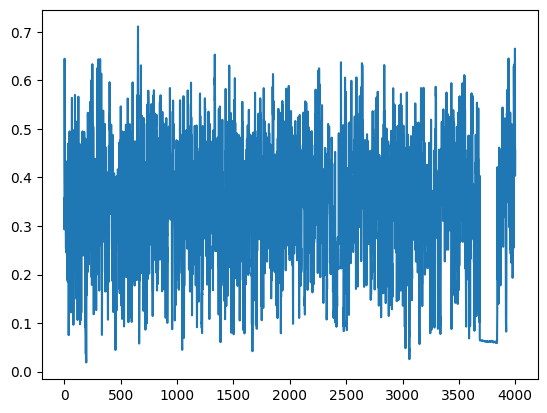

In [41]:
plt.plot(fit_time.length_scale)

<Axes: >

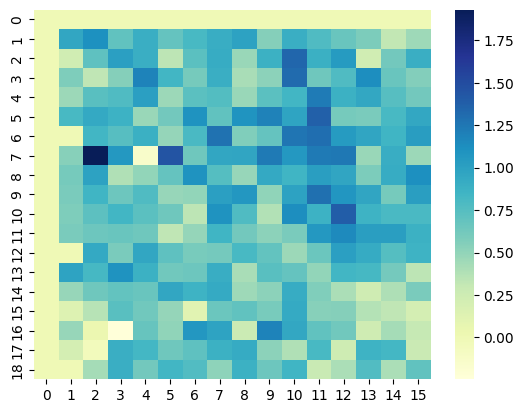

In [51]:
PLT_ROW = df.groupby('PLT_ID')[['ROW', 'COL']].max()['ROW']
PLT_COL = df.groupby('PLT_ID')[['ROW', 'COL']].max()['COL']
mean_matrix_time = np.zeros((np.max(PLT_ROW)+1, np.max(PLT_COL)+1))
mean_matrix_time[PLT_ROW, PLT_COL] = fit_time.plot.mean(axis=0)
sns.heatmap(mean_matrix_time, cmap="YlGnBu")

In [55]:
fit_time.time_effect.mean(axis=0).shape

(9612,)

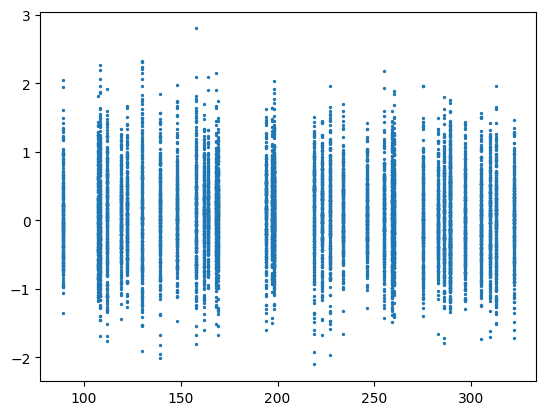

In [66]:
plt.scatter(stan_data_time["day"],fit_time.time_effect.mean(axis=0),s=2)

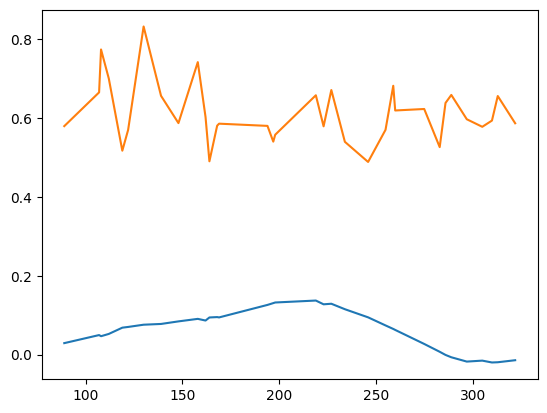

In [72]:
df['time_effect_mean'] = fit_time.time_effect.mean(axis=0)
plt.plot(df.groupby("DAY_OF_YEAR")['time_effect_mean'].mean()) # blue line, mean
plt.plot(df.groupby("DAY_OF_YEAR")['time_effect_mean'].std()) # orange line, standard deviation

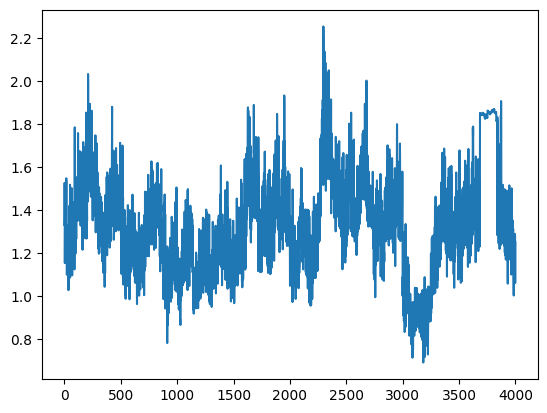

In [77]:
plt.plot(fit_time.sigma)

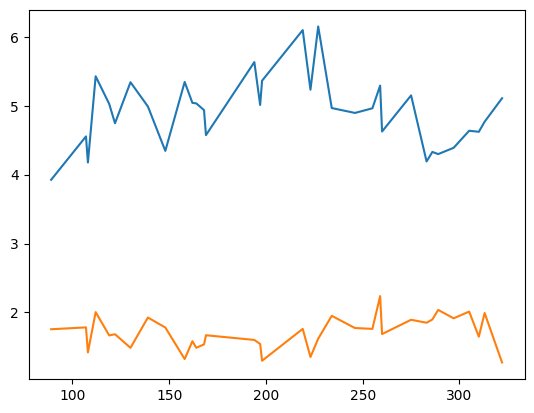

In [80]:
plt.plot(df.groupby("DAY_OF_YEAR")['QUALITY'].mean()) 
plt.plot(df.groupby("DAY_OF_YEAR")['QUALITY'].std()) 